In [1]:
from torch import nn
import torch.nn.functional as F
import sys
import torch
import copy
import numpy as np
import pandas as pd
from collections import namedtuple, deque
from torch import optim
from torch.distributions import Categorical, Bernoulli
import matplotlib.pyplot as plt
from IPython.display import clear_output
import operator
import copy
import random
import os

sys.path.append("../")
sys.path.append("../model")
from environment import Environment
from dgnAgent import Agent
from trainer import Trainer
from wrapper import CrossProductWrapper as CPW
from replayBuffer import ReplayBuffer
import functions as fc
# Constants
KIND_CARS = 8
INPUT_SEQUENCE_LENGTH = 100
INPUT_WINDOW = 7
OUTPUT_SEQUENCE_LENGTH = 4
NUM_LINES = 4
CAPACITY_LINES = 3

In [2]:
# Constants Agent
BUFFER_SIZE = int(1e7)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 1          # discount factor
TAU = 0.001#1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
SEED = 0
NUM_OPTIONS = 30
TERMINATION_REG = 0.01
ENTROPY_REG = 0.01

initial_ratio = 0.6

In [3]:
class Network(nn.Module):
    def __init__(self, layer_numbers):
        super().__init__()
        self.state = nn.Sequential(
            nn.Linear(layer_numbers[0], layer_numbers[1]),
            nn.ReLU(),
            nn.Linear(layer_numbers[1], layer_numbers[2]),
            nn.ReLU(),
            nn.Linear(layer_numbers[2], layer_numbers[3]),
            nn.ReLU(),
            nn.Linear(layer_numbers[3], layer_numbers[4]),
            nn.ReLU()
        )
        self.Q            = nn.Linear(128, NUM_OPTIONS)                 # Policy-Over-Options
        self.terminations = nn.Linear(128, NUM_OPTIONS)                 # Option-Termination
        self.options_W = nn.Parameter(torch.zeros(NUM_OPTIONS, 128, NUM_LINES*NUM_LINES)) # we need two network so indiv Q and term
        self.options_b = nn.Parameter(torch.zeros(NUM_OPTIONS, NUM_LINES*NUM_LINES))  


In [4]:
class Agent():
    def __init__(self, q_network, buffer_size, batch_size, update_every, gamma, tau, lr,  seed):

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.qnetwork_local = copy.deepcopy(q_network)
        self.qnetwork_target = copy.deepcopy(q_network)
        self.seed = random.seed(seed)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, seed)
        
        self.temperature = 1
        self.t_step = 0

    def get_Q(self, state):
        return self.qnetwork_local.Q(state)
    
    def reset_memory(self):
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, self.seed)

    def predict_option_termination(self, state, current_option):
        state = torch.tensor(state).float()
        state = self.qnetwork_local.state(state)
        termination = self.qnetwork_local.terminations(state).softmax(dim = -1)
        termination = termination[current_option]
        #termination = self.qnetwork_local.terminations(state)[current_option].sigmoid()
        option_termination = Bernoulli(termination).sample()
        Q = self.get_Q(state)
        next_option = Q.argmax(dim=-1)
        return bool(option_termination.item()), next_option.item()
    
    def get_terminations(self, state):
        return self.qnetwork_local.terminations(state).softmax(dim = -1)

    def greedy_option(self, state):
        state = to_tensor(state)
        state = self.qnetwork_local.state(state)
        Q = self.get_Q(state)
        return Q.argmax(dim=-1).item()
    
    def step(self, state, current_option, reward, next_state, done, logp, entropy):
        self.memory.add(state, current_option, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if (len(self.memory)) > BATCH_SIZE:
            actor_loss_val = actor_loss(state, current_option, logp, entropy, \
                reward, done, next_state, self.qnetwork_local, self.qnetwork_target)
            loss = actor_loss_val
            if self.t_step == 0:        
                samples = self.memory.sample()
                self.learn(samples, self.gamma, loss)

    def act(self, state, eps, option):
        state = to_tensor(state)
        state = self.qnetwork_local.state(state)
        logits = state @ self.qnetwork_local.options_W[option] + self.qnetwork_local.options_b[option]
        action_dist = (logits / self.temperature).softmax(dim=-1) # high temp makes softmax output closer        
        action_dist = Categorical(action_dist)                    # like multinomial dist

        action = action_dist.sample()
        logp = action_dist.log_prob(action)
        entropy = action_dist.entropy()
        return action.item(), logp, entropy
    
    #for test you need to write in the script itself to choose epsilon option

    def learn(self, samples, gamma, loss):
        states, options, rewards, next_states, dones = samples
        critic_loss_val = critic_loss(self.qnetwork_local, self.qnetwork_target, samples)
        loss += critic_loss_val
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

    # return buffer_size, batch_size, update_every, gamma, tau
    def get_stats(self):
        return self.buffer_size, self.batch_size, self.update_every, self.gamma, self.tau, self.lr

def critic_loss(model, model_prime, data_batch):
    obs, options, rewards, next_obs, dones = data_batch
    batch_idx = torch.arange(len(options)).long()
    masks     = 1 - torch.FloatTensor(dones)

    # The loss is the TD loss of Q and the update target, so we need to calculate Q
    states = model.state(to_tensor(obs)).squeeze(0)
    Q      = model.Q(states)
    
    # the update target contains Q_next, but for stable learning we use prime network for this
    next_states_prime = model_prime.state(to_tensor(next_obs)).squeeze(0)
    next_Q_prime      = model_prime.Q(next_states_prime) # detach?

    # Additionally, we need the beta probabilities of the next state
    next_states            = model.state(to_tensor(next_obs)).squeeze(0)
    #next_termination_probs = self.get_terminations(next_states)
    next_termination_probs = model.terminations(next_states).softmax(dim = -1)
    next_options_term_prob = next_termination_probs[batch_idx, options]

    # Now we can calculate the update target gt
    gt = rewards + masks * GAMMA * \
        ((1 - next_options_term_prob) * next_Q_prime[batch_idx, options] + next_options_term_prob  * next_Q_prime.max(dim=-1)[0])

    # to update Q we want to use the actual network, not the prime
    td_err = F.mse_loss(Q[batch_idx, options], gt.detach())
    return td_err

def actor_loss(obs, option, logp, entropy, reward, done, next_obs, model, model_prime):
    state = model.state(to_tensor(obs))
    next_state = model.state(to_tensor(next_obs))
    next_state_prime = model_prime.state(to_tensor(next_obs))

    
    #option_term_prob = self.get_terminations(state)[option]
    #next_option_term_prob = self.get_terminations(next_state)[option]

    option_term_prob = model.terminations(state).softmax(dim = -1)[option]
    next_option_term_prob = model.terminations(next_state).softmax(dim = -1)[option]
    
    Q = model.Q(state).detach().squeeze()
    next_Q_prime = model_prime.Q(next_state_prime).detach().squeeze()

    # Target update gt
    gt = reward + (1 - done) * GAMMA * \
        ((1 - next_option_term_prob) * next_Q_prime[option] + next_option_term_prob  * next_Q_prime.max(dim=-1)[0])

    # The termination loss
    termination_loss = option_term_prob * (Q[option].detach() - Q.max(dim=-1)[0].detach() + TERMINATION_REG) * (1 - done)
    #termination_loss = 0
    # actor-critic policy gradient with entropy regularization
    policy_loss = -logp * (gt.detach() - Q[option]) - ENTROPY_REG * entropy #-logp*A - regularisation
    actor_loss = termination_loss + policy_loss
    return actor_loss



In [5]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

In [6]:
class Trainer():

    def __init__(self, checkpoint_name, kind_cars, gamma):
        self.kind_cars = kind_cars
        self.gamma = gamma
        self.best_score = -float("inf")
        pathname = fc.get_path()
        counter = 0
        dirname = checkpoint_name + "_" + str(counter)
        while dirname in os.listdir(pathname + '/results'):
            counter += 1
            dirname = checkpoint_name + "_" + str(counter)
        self.checkpoint_name = dirname
        self.run_number = counter

    def save_settings(self, env, agent, multi_agent = False, curricular = None):
        pathname = fc.get_path()

        # get settings from env and agent
        input_sequence_length, kind_cars, num_lines, capacity_lines, output_sequence_length, input_window_length = env.get_stats()
        buffer_size, batch_size, update_every, gamma, tau, lr = agent.get_stats()

        # check if folder exists. create it otherwise
        os.system("mkdir " + pathname + "/results/" + self.checkpoint_name)


        filename =  self.checkpoint_name  + ('_' + curricular if curricular else '')
        filename =  filename + ".settings"

        f = open(pathname +"/results/" + self.checkpoint_name + "/" + filename, "a")
        f.write("Gamma " + str(self.gamma) +"\n")
        f.write("Buffer Size " + str(buffer_size) +"\n")
        f.write("Batch Size " + str(batch_size) +"\n")
        f.write("Update Every " + str(update_every) +"\n")
        f.write("Tau " + str(tau) +"\n")
        f.write("LR " + str(lr) +"\n")

        f.write("Kind cars " + str(self.kind_cars) +"\n")
        f.write("Input length " + str(input_sequence_length) +"\n")
        f.write("Output length " + str(output_sequence_length) +"\n")
        f.write("Capacity Lines " + str(capacity_lines) +"\n")
        f.write("Num Lines " + str(num_lines) +"\n")
        if multi_agent:
            f.write("Multi Agent\n")
        if curricular:
            f.write("Curricular - Front and Back same settings")

        f.close()


    def linearize(self, states):
        return fc.linearize(states, self.kind_cars)

 
    def train(self, env, agent, checkpoint_length, n_episodes=8000, eps_start=1.0, eps_end=0.0001,
                 eps_decay=0.999, show_picture = False, valid_actions_only = False):

        # initialise saving spots for better reading in the code
        run_number = self.save_settings(env, agent)
        pathname = fc.get_path()

        best_score_weigths_filename = pathname + "/results/" + self.checkpoint_name + "/" + self.checkpoint_name  + '_highScore.pth'
        weights_filename = pathname + "/results/" + self.checkpoint_name + "/" + self.checkpoint_name +  '.pth'
        scores_filename = pathname + "/results/" + self.checkpoint_name + "/" + self.checkpoint_name + '.scores'


        # status variables and plots
        scores = []  # list containing scores from each episode
        means = []
        scores_window = deque(maxlen=checkpoint_length)  # last 100 scores
        eps = eps_start  # initialize epsilon

        for i_episode in range(1, n_episodes + 1):
            env.reset()
            state = env.get_state()
            state = self.linearize(state)
            score = 0
            option_lengths = {opt:[] for opt in range(NUM_OPTIONS)} 
            greedy_option  = agent.greedy_option(state)
            current_option = 0
            option_termination = True
            curr_op_len = 0
            done = False
            
            counter = 0
            while not done:
                if option_termination:
                    option_lengths[current_option].append(curr_op_len)
                    current_option = np.random.choice(NUM_OPTIONS) if np.random.rand() < eps else greedy_option
                    curr_op_len = 0
    
                action, logp, entropy = agent.act(state, eps, current_option)
                reward, next_state, done = env.step(action) # send the action to the environment and observe
                next_state = self.linearize(next_state)
            
                agent.step(state, current_option, reward, next_state, done, logp, entropy)
            
                state = next_state
                score += reward
                
                option_termination, greedy_option = agent.predict_option_termination(state, current_option)
                #action = agent.act(state, eps, eval_mode = valid_actions_only, pa = env.possible_actions())
                if done:
                    break
                    
            scores_window.append(score)
            scores.append(score)
            eps = max(eps_end, eps_decay * eps)
            
            means.append(np.mean(scores_window))

            if i_episode % checkpoint_length == 0:

                score = np.mean(scores_window)
                # if current score is better, save the network weights and update best seen score
                if score > self.best_score:
                    self.best_score = score
                    torch.save(agent.qnetwork_local.state_dict(), best_score_weigths_filename)
                if show_picture:
                    clear_output(wait=True)
                    plt.scatter(range(len(scores)), scores, label='Scores', color='c', alpha=0.8, s=1)
                    plt.plot(np.arange(len(means)), means, label='Mean', color='r')
                    plt.ylabel('Score')
                    plt.xlabel('Episode #')
                    plt.show()
                print('\rEpisode {}\tAverage Score: {:.2f}\tBest Score: {:.2f}'.format(i_episode, score, self.best_score))

                f = open(scores_filename, "a")
                for score in scores_window:
                    f.write(str(score) + '\n')
                f.close()

        torch.save(agent.qnetwork_local.state_dict(), weights_filename)
        return scores

In [7]:
for i in [7]:
    INPUT_WINDOW = i
    # important for network specific stuff
    layers = [(INPUT_WINDOW + OUTPUT_SEQUENCE_LENGTH+NUM_LINES*CAPACITY_LINES)*(KIND_CARS+1),128,128,128,128,NUM_LINES*NUM_LINES]
    net = Network(layers)
    # create name
    name = 'HRLCP_I:' + str(INPUT_WINDOW) + "_O:" + str(OUTPUT_SEQUENCE_LENGTH) + "_N:"
    for layer in layers:
       name += str(layer) + "-"
    name = name[:-1]
    name += "_NL:" + str(NUM_LINES) + "_CL:" + str(CAPACITY_LINES) + "_W:" + str(INPUT_SEQUENCE_LENGTH) + "_KC:" + str(KIND_CARS)
    # initialize training


In [8]:
env = Environment(INPUT_SEQUENCE_LENGTH, KIND_CARS, NUM_LINES, CAPACITY_LINES, OUTPUT_SEQUENCE_LENGTH, INPUT_WINDOW, initial_ratio = initial_ratio)
cpw = CPW(env)
agent = Agent(net, BUFFER_SIZE, BATCH_SIZE, UPDATE_EVERY, GAMMA, TAU, LR, SEED)
trainer = Trainer(name, KIND_CARS, GAMMA)

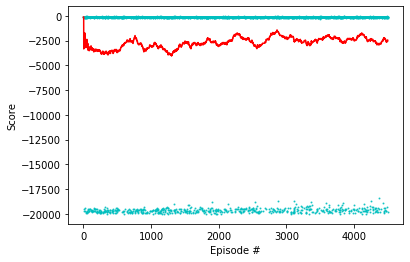

Episode 4500	Average Score: -2531.80	Best Score: -667.73


/home/shadowwalker/anaconda3/envs/RIL/lib/python3.7/site-packages/torch/tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
scores = trainer.train(cpw, agent, 250, n_episodes=10250, eps_start=1.0, eps_end=0.001, eps_decay=0.9998, show_picture= True, valid_actions_only = True)